In [2]:
# ! pip install torchsummary

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

C:\annaconda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\annaconda\envs\tf\lib\site-packages\transformers\utils\generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
num_classes = 41
batch_size = 32
num_epochs = 5
learning_rate = 0.001

transformation, augmentation and normalization

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_dir = './plants'

# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

In [6]:
# Create data loaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                             shuffle=True, num_workers=4)
               for x in ['train', 'valid']}

In [7]:
#dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

In [8]:
dataset_sizes

{'train': 74993, 'valid': 19249}

In [9]:
class_names = image_datasets['train'].classes
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)_Powdery_mildew',
 'Cherry_(including_sour)_healthy',
 'Corn_(maize)_Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)_Common_rust',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)_healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite

In [10]:
# Load pre-trained ResNet-50 model
model = models.resnet101(pretrained=True)

C:\annaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\annaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Kashyap Ghimire/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|███████████████████████████████████████████████████████████████████████████████| 171M/171M [00:10<00:00, 17.3MB/s]


In [11]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

In [12]:
# Modify the final layer to match the number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

In [13]:
# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

In [14]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [15]:
# Display the model architecture and number of trainable parameters
def display_model_info(model):
    # Summary of the model
    print("Model Architecture:")
    summary(model, (3, 224, 224))

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nNumber of trainable parameters: {trainable_params}")

display_model_info(model)


Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-1

In [16]:
# Function to train the model
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Track loss and accuracy
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            num_batches = len(dataloaders[phase])
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Calculate and display progress
                progress = (batch_idx + 1) / num_batches * 100
                print(f"\r{phase} Progress: {progress:.2f}% Complete", end='')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f'\n{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [17]:
# Train and evaluate the model
best_model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/4
----------
train Progress: 100.00% Complete
train Loss: 0.6474 Acc: 0.8185
valid Progress: 100.00% Complete
valid Loss: 0.2674 Acc: 0.9136

Epoch 1/4
----------
train Progress: 100.00% Complete
train Loss: 0.3890 Acc: 0.8775
valid Progress: 100.00% Complete
valid Loss: 0.2976 Acc: 0.9084

Epoch 2/4
----------
train Progress: 100.00% Complete
train Loss: 0.3565 Acc: 0.8875
valid Progress: 100.00% Complete
valid Loss: 0.2387 Acc: 0.9211

Epoch 3/4
----------
train Progress: 100.00% Complete
train Loss: 0.3348 Acc: 0.8946
valid Progress: 100.00% Complete
valid Loss: 0.1950 Acc: 0.9341

Epoch 4/4
----------
train Progress: 100.00% Complete
train Loss: 0.3232 Acc: 0.8997
valid Progress: 100.00% Complete
valid Loss: 0.1883 Acc: 0.9375

Training complete in 45m 9s
Best val Acc: 0.937451


In [18]:
# Save the best model
torch.save(best_model.state_dict(), 'modelresnet101.pth')

Loss and accuracy graph function

In [22]:
checkpoint = {
    "model_state": best_model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_loss": train_loss,
    "val_loss": val_loss,
    "val_accuracy": val_acc
}
torch.save(checkpoint, 'checkpoint.pth.tar')

In [23]:
def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


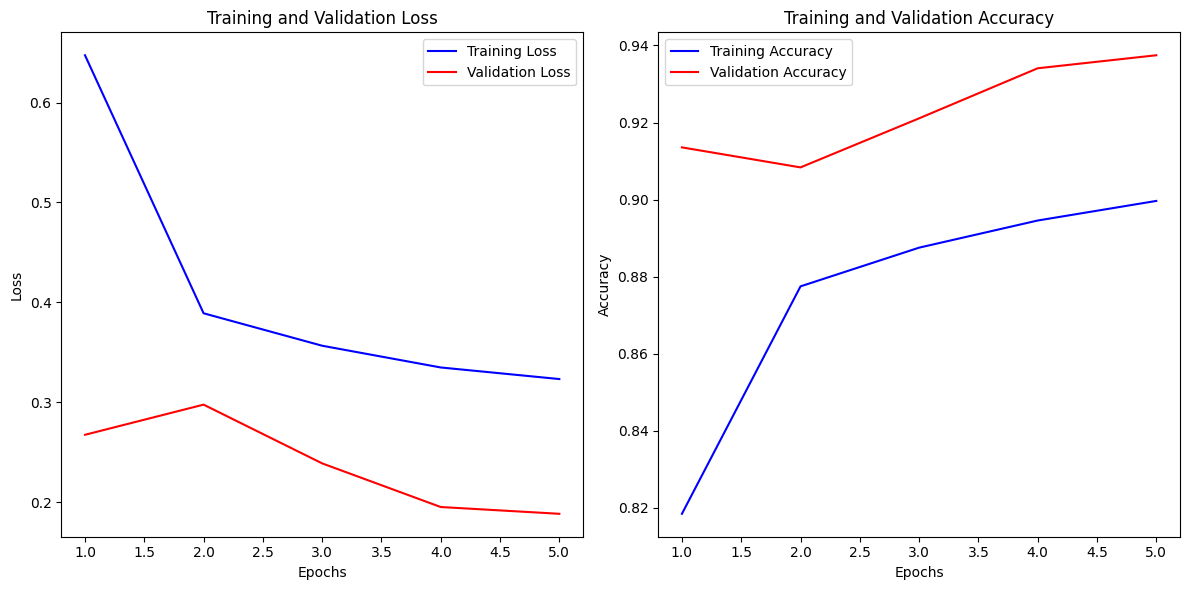

In [24]:
plot_training_history(train_loss, val_loss, train_acc, val_acc)


In [25]:
# Function to print classification report
def print_classification_report(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print("Classification Report:\n")
    print(report)


In [26]:
# Print classification report for the validation set
print_classification_report(best_model, dataloaders['valid'])

Classification Report:

                                                  precision    recall  f1-score   support

                              Apple___Apple_scab     0.9184    0.9821    0.9492       504
                               Apple___Black_rot     0.9879    0.9859    0.9869       497
                        Apple___Cedar_apple_rust     1.0000    0.9477    0.9732       440
                                 Apple___healthy     0.9893    0.9203    0.9536       502
                             Blueberry___healthy     1.0000    0.9251    0.9611       454
          Cherry_(including_sour)_Powdery_mildew     0.9928    0.9810    0.9869       421
                 Cherry_(including_sour)_healthy     1.0000    0.9671    0.9833       456
Corn_(maize)_Cercospora_leaf_spot Gray_leaf_spot     0.8976    0.9195    0.9084       410
                        Corn_(maize)_Common_rust     0.9979    0.9937    0.9958       477
             Corn_(maize)___Northern_Leaf_Blight     0.9262    0.9203    0.

testing

In [32]:
import os

# Define the path to the main folder
main_folder_path = './plants/train'  # Replace with the path to your folder

# List all directories (child folders) in the main folder
child_folders = [d for d in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, d))]


# Create a dictionary to map each index to a child folder name
index_folder = {index: folder_name for index, folder_name in enumerate(child_folders)}

# Print the dictionary
print(index_folder)

{0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'blast', 5: 'blight', 6: 'Blueberry___healthy', 7: 'Cherry_(including_sour)_healthy', 8: 'Cherry_(including_sour)_Powdery_mildew', 9: 'Corn_(maize)_Cercospora_leaf_spot Gray_leaf_spot', 10: 'Corn_(maize)_Common_rust', 11: 'Corn_(maize)_healthy', 12: 'Corn_(maize)___Northern_Leaf_Blight', 13: 'Grape___Black_rot', 14: 'Grape___Esca_(Black_Measles)', 15: 'Grape___healthy', 16: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 17: 'Orange___Haunglongbing_(Citrus_greening)', 18: 'Peach___Bacterial_spot', 19: 'Peach___healthy', 20: 'Pepper,_bell___Bacterial_spot', 21: 'Pepper,_bell___healthy', 22: 'Potato___Early_blight', 23: 'Potato___healthy', 24: 'Potato___Late_blight', 25: 'Raspberry___healthy', 26: 'Soybean___healthy', 27: 'Squash___Powdery_mildew', 28: 'Strawberry___healthy', 29: 'Strawberry___Leaf_scorch', 30: 'Tomato___Bacterial_spot', 31: 'Tomato___Early_blight', 32: 'Tomato___healt

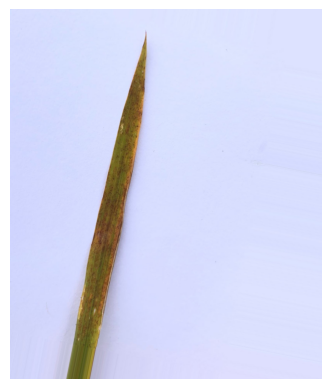

Predicted class: tungro


In [49]:
#loading the saved model to check test sets image and the detected diseases.
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

# Load the model architecture (modify according to your specific model)
model = models.resnet101(pretrained=False)  # Adjust this line if you used a different architecture
model.fc = torch.nn.Linear(model.fc.in_features, 41)  # Adjust the number of classes if necessary

# Load the trained model weights
model.load_state_dict(torch.load('modelresnet101.pth'))
model.eval()  # Set the model to evaluation mode

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load and preprocess the image
image_path = './plants/test/test/Rice-tungro_70.jpeg'  # Path to your test image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()
image = transform(image)
image = image.unsqueeze(0)  # Add batch dimension

# Make prediction
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

# Print the predicted class

print(f'Predicted class: {index_folder[predicted.item()]}')
